<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2023notebooks/2023_1030Knd_Ijn_Ask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_format = 'retina'
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

* date: 2023_1027
* author: 浅川伸一
* filename: 2023_1030Knd_Ijn_Ask.ipynb

# 符号化器‐復号化器 (encoder-decoder a.k.a seq2seq) モデルによる，単語復唱，単語産出，および単語理解処理過程の実装

<center>
<!-- <img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4c.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4d.svg"><br/> -->
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4ab.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4c.svg">
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4d.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/1999Levelt_blueprint.jpg" width=49%"><br/>
<!-- <img src="2004Harm_Seidenberg_fig4ab.svg"><br/>
<img src="2004Harm_Seidenberg_fig4c.svg">
<img src="2004Harm_Seidenberg_fig4d.svg"><br/> -->
`Harm & Seidenberg (2004)`, Figure 4 c, and d,
`Levelt 1999
</center>

<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2015Loung_fig1.svg" width="49%"><br/>
<!-- <img src="2015Loung_fig1.svg" width="24%"><br/> -->
ニューラル翻訳モデル。
青色がソース言語モデル，赤がターゲット言語モデルである。
ソース言語モデルの，最終時刻の中間層状態を，ターゲット言語モデルの開始時の中間層状態として用いる。
Loung+2015 Fig.1 より。    
</center>

<!-- <center>
<img src="2015Loung_fig1.svg" width="24%"><br/>
ニューラル翻訳モデル。
青色がソース言語モデル，赤がターゲット言語モデルである。
ソース言語モデルの，最終時刻の中間層状態を，ターゲット言語モデルの開始時の中間層状態として用いる。
Loung+2015 Fig.1 より。    
</center> -->


* 文献
    * Harm & Seidenberg (2004) Computing the Meanings of Words in Reading: Cooperative Division of Labor Between Visual and Phonological Processes, Psychological Review, DOI:10.1037/0033-295X.111.3.662
    * Seq2seq 翻訳モデル: Sutskever+ (2014) Sequence to Sequence Learning with Neural Networks, [arXiv:1409.3215](https://arxiv.org/abs/1409.3215)
    * 注意つき符号化器‐復号化器モデル: Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, [arXiv:1409.0473](https://arxiv.org/abs/1409.0473)
    * もう一つの注意つき符号化器‐復号化器モデル Luong+ (2015) Effective Approaches to Attention-based Neural Machine Translation, [arXiv:1508.04025](https://arxiv.org/abs/1508.04025)


# 0 準備



## 0.1 Colab 用 MeCab コンパイル&インストール等

In [ ]:
%%time
import sys
import os
import numpy as np
from tqdm.notebook import tqdm
import time
import datetime
import matplotlib.pyplot as plt

# ローカルと colab との相違を吸収するために必要となるライブラリをインストール
try:
    import jaconv
except ImportError:
    !pip install jaconv

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

if isColab:
    !pip install --upgrade termcolor==1.1
from termcolor import colored

try:
    import RAM
except ImportError:
    !git clone https://github.com/ShinAsakawa/RAM.git
    import RAM

# 近藤先生との議論から音韻情報の代替案として，ローマ字表記を採用することとした。
# このとき，訓令式の表記にすることとした。ヘボン式，パスポート式ではないことに注意
try:
    from kunrei import kunrei
except ImportError:
    !wget https://shinasakawa.github.io/2023notebooks/kunrei.py -O kunrei.py
    from kunrei import kunrei

## 0.2 意味表現として word2vec による意味埋め込みベクトルを使う

In [ ]:
# word2vec のため gensim を使う
import requests
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import os
HOME = os.environ['HOME']

w2v_2017 = {
    'cbow200': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz',
    'sgns200': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_sgns.bin.gz',
    'cbow300': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid300_win20_neg20_sgns.bin.gz',
    'sgns300': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz'
}

w2v_2021 = {
    'cbow128': { 'id': '1B9HGhLZOja4Xku5c_d-kMhCXn1LBZgDb',
                'outfile': '2021_05jawiki_hid128_win10_neg10_cbow.bin.gz'},
    'sgns128': { 'id': '1OWmFOVRC6amCxsomcRwdA6ILAA5s4y4M',
                'outfile': '2021_05jawiki_hid128_win10_neg10_sgns.bin.gz'},
    'cbow200': { 'id': '1JTkU5SUBU2GkURCYeHkAWYs_Zlbqob0s',
                'outfile': '2021_05jawiki_hid200_win20_neg20_sgns.bin.gz'}
}

is2017=True

if isColab:
    from google_drive_downloader import GoogleDriveDownloader as gdd

    if is2017:
        response = requests.get(w2v_2017['cbow200'])
        fname = w2v_2017['cbow200'].split('/')[-1]
        with open(fname, 'wb') as f:
            f.write(response.content)
    else:
        #訓練済 word2vec ファイルの取得
        (f_id, outfile) = w2v_2021['sgns128']['id'], w2v_2021['sgns128']['outfile']
        gdd.download_file_from_google_drive(file_id=f_id,
                                            dest_path=outfile,
                                            unzip=False,
                                            showsize=True)

if is2017:
    w2v_base = os.path.join(HOME, 'study/2016wikipedia/') if not isColab else '.'
    w2v_file = '2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz'
    w2v_file = os.path.join(w2v_base, w2v_file)
else:
    w2v_base = os.path.join(HOME, 'study/2019attardi_wikiextractor.git/wiki_texts/AA') if isMac else '.'
    w2v_file = '2021_05jawiki_hid128_win10_neg10_sgns.bin'

w2v = KeyedVectors.load_word2vec_format(w2v_file,
                                        encoding='utf-8',
                                        unicode_errors='replace',
                                        binary=True)

## 0.3 データセット Psylex71_Dataset の読み込み

In [ ]:
# データセットとしての Psylex71_Dataset の読み込み
from RAM import Psylex71_Dataset

psylex71_ds = Psylex71_Dataset(max_words=30000)
print(f'psylex71_ds の単語数:{psylex71_ds.__len__()}')

psylex71_ds の単語数:30000


### データセットのヒストグラム描画

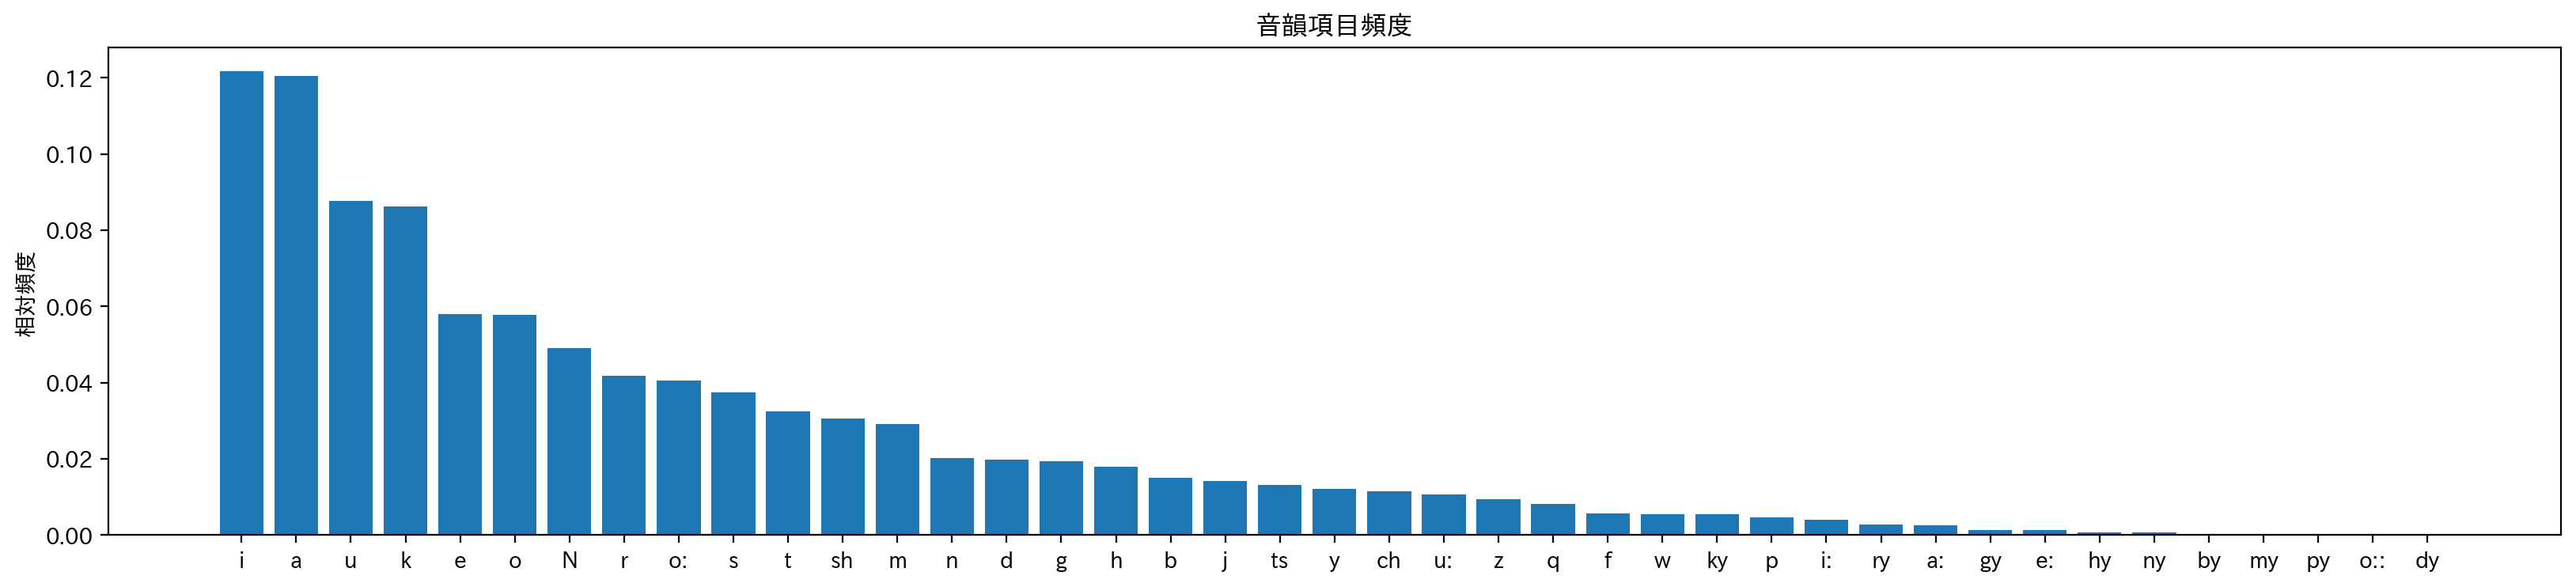

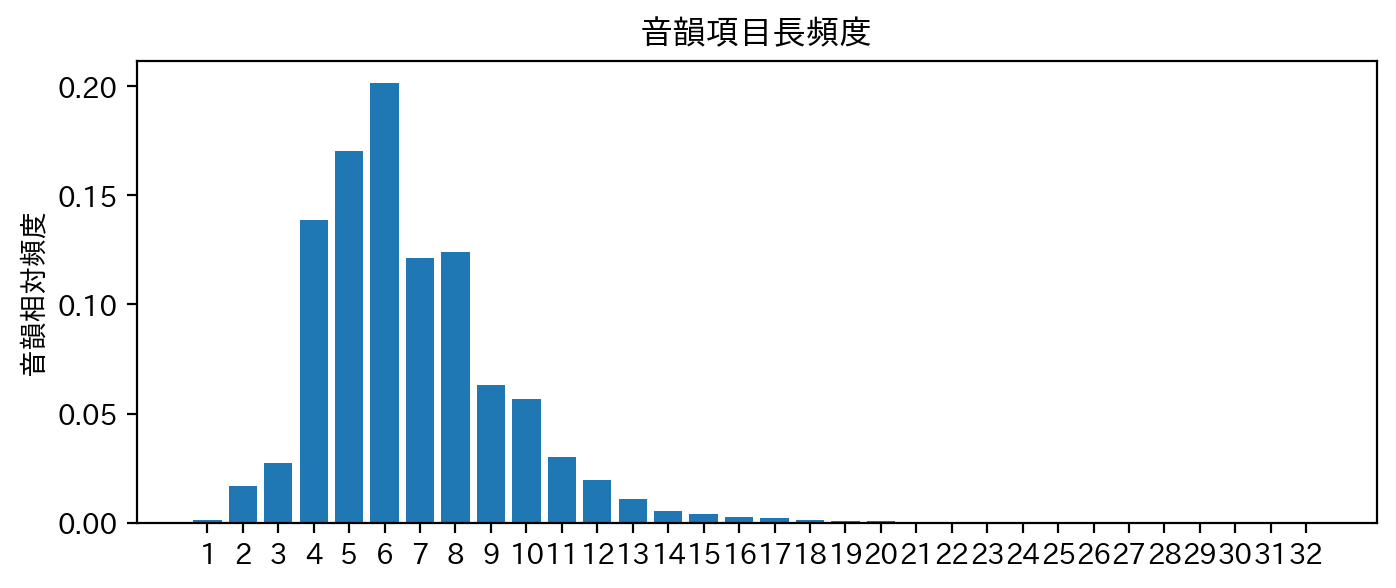

In [ ]:
from RAM import draw_word_char_histgram

draw_word_char_histgram(_dict=psylex71_ds.data_dict, key='phon', title='音韻', figsize2=(8,3))

## 0.4 psylex71_ds に存在する全単語を word2vec の埋め込みベクトル行列にする

In [ ]:
# psylex71_ds データから word2vec の埋め込みベクトル行列を得る
_words = [dct['orth'] for dct in psylex71_ds.data_dict.values()]

# gensim() の `vectors_for_all()` 関数を持ちて，望む語彙で構成される word2vec 単語埋め込みモデルを作成
w2v_psylex71 = w2v.vectors_for_all(_words)

# NaN データが入っている可能性がるので変換
w2v_psylex71.vectors = np.nan_to_num(w2v_psylex71.vectors)
print(f'w2v_psylex71.vectors.shape:{w2v_psylex71.vectors.shape}')
words = w2v_psylex71.index_to_key
#len(words)

w2v_psylex71.vectors.shape:(26877, 200)


## 0.5 psylex71 データセット中の単語における w2v の表示テスト

In [ ]:
Wrd = input('単語を入力してください:')
color = 'blue'
while (Wrd != ""):
    if Wrd in w2v_psylex71:
        Idx = w2v_psylex71.key_to_index[Wrd]
        print(f'入力単語 Wrd:{colored(Wrd, color, attrs=["bold"])},',
              f'対応する単語番号 Idx:{colored(Idx, color, attrs=["bold"])},',
              f'w2v_psylex71.get_index({Wrd}):{colored(w2v_psylex71.get_index(Wrd), color, attrs=["bold"])}')
    else:
        print(colored(f'{Wrd} という単語はありません。','red', attrs=['bold']))
    Wrd = input('単語を入力してください (終了するには改行のみを入力):')

単語を入力してください:英語
入力単語 Wrd:英語, 対応する単語番号 Idx:1652, w2v_psylex71.get_index(英語):1652
単語を入力してください (終了するには改行のみを入力):


## 0.6 書記素リストの作成

In [ ]:
import RAM

def _grapheme(words=words):
    """必要と思われる書記素リストを返す"""

    num_alpha='０１２３４５６７８９ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ'
    hira = 'あいうえおかがきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよらりるれろわゐゑをんぁぃぅぇっゃゅょゎ'+'ゔ'
    kata = 'アイウエオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモヤユヨラリルレロワヰヱヲン'+'ヴヷヸヹヺァィゥヵヶェォッャョュヮ'
    symbols='、。，．・：；？！゛゜´｀¨＾‾＿ヽヾゝゞ〃仝々〆〇ー—‐／＼〜‖｜…‥‘’“”（）〔〕［］｛｝〈〉《》「」『』【】＋−±×÷＝≠＜＞≦≧∞∴♂♀°′″℃¥＄¢£％＃＆＊＠§☆★○●◎◇' + '◆□■△▲▽▼※〒→←↑↓〓∈∋⊆⊇⊂⊃∪∩∧∨¬⇒⇔∀∃∠⊥⌒∂∇≡≒≪≫√∽∝∵∫∬Å‰♯♭♪†‡¶◯'
    #greek='ΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩαβγδεζηθικλμνξοπρστυφχψω'
    #rosian='АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    #digit_symbols='①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽⑾⑿⒀⒁⒂⒃⒄⒅⒆⒇❶❷❸❹❺❻❼❽❾⒈⒉⒊⒋⒌⒍⒎⒏⒐'
    #alpha_symbols='ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩⅪⅫⅰⅱⅲⅳⅴⅵⅶⅷⅸⅹⅺⅻ⒜⒝⒞⒟⒠⒡⒢⒣⒤⒥⒦⒧⒨⒩⒪⒫⒬⒭⒮⒯⒰⒱⒲⒳⒴⒵'
    #units='㎜㎟㎝㎠㎤㎡㎥㎞㎢㎎㎏㏄㎖㎗ℓ㎘㎳㎲㎱㎰℉㏔㏋㎐㎅㎆㎇№㏍℡'
    #suits='♤♧♡♢♠♣♥♦〠☎〄☞☜☝☟⇆⇄⇅⇨⇦⇧⇩'
    #etc='①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩ㍉㌔㌢㍍㌘㌧㌃㌶㍑㍗㌍㌦㌣㌫㍊㌻㎜㎝㎞㎎㎏㏄㎡㍻〝〟№㏍℡㊤㊥㊦㊧㊨㈱㈲㈹㍾㍽㍼≒≡∫∮∑√⊥∠∟⊿∵∩∪㊙'
    #etc2='㍉㌢㍍㌔㌖㌅㌳㍎㌃㌶㌘㌕㌧㍑㍊㌹㍗㌍㍂㌣㌦㌻㌫㌀㌞㌪㌱㍇㍾㍽㍼㍻㍿∮∟⊿〝'

    # RAM で作成済の常用漢字リストを用いて単漢字リストを作成
    # 平成 22 年の改定により常用漢字は 2136 文字ある
    chars_list = [ch for ch in num_alpha+hira+kata+symbols]+ RAM.chars_joyo().char_list
    not_chars_list = []
    for wrd in tqdm(words):
        for ch in wrd:
            if (ch not in chars_list) and (ch not in not_chars_list):
                not_chars_list.append(ch)
    not_chars_list = sorted(not_chars_list)
    grapheme = chars_list + not_chars_list
    # 上記の処理により grapheme には 2768 文字である。
    # これに特殊トークン 4 つ ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] を加えたリストを返す

    return ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + grapheme

grapheme = _grapheme()

  0%|          | 0/26877 [00:00<?, ?it/s]

## 0.7 PyTorch 用のデータセット定義

In [ ]:
from torch.utils.data import Dataset
import gensim

class psylex71_w2v_Dataset(Dataset):
    def __init__(self,
                 #direction='s2p',  # ['s2p', 'p2s']
                 source='seme',    # エンコーダ用 入力データ, ['orth', seme', 'phon'] のいずれか一つ
                 target='phon',    # デコーダ用 出力データ ,  ['orth', seme', 'phon'] のいずれか一つ
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_psylex71,
                 old_ds:RAM.dataset.Psylex71_Dataset=psylex71_ds,
                 #mecab_yomi=yomi,
                 grapheme:list=grapheme,
                ):

        super().__init__()
        self.ds_name = 'psylex71'+source+"2"+target
        self.source, self.target = source, target

        #self.direction = 's2p' if direction == 's2p' else direction
        self.w2v = w2v
        self.old_ds = old_ds
        #self.mecab_yomi = yomi         # 未知の単語が入力された場合 MeCab を使って読みをえるため
        self.grapheme = grapheme

        self.words = w2v.index_to_key  # gensim の KeyedVectors を利用して単語リストとする
        self.W = w2v.vectors

        # 訓令式に従った日本語ローマ字表記 `kurei.py` 参照
        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>', # 特殊トークン，純に，埋め草，語頭，語末，未知
                        'a', 'i', 'u', 'e', 'o',            # 母音
                        'a:', 'i:', 'u:', 'e:', 'o:',       # 長母音
                        'N', 'Q',                           # 撥音，拗音
                        'b', 'by', 'ch', 'd', 'dy', 'f', 'g', 'gy', 'h', 'hy', # 子音
                        'j', 'k', 'ky', 'm', 'my', 'n', 'ny',  'p', 'py', 'r', # 子音
                        'ry', 's', 'sy', 't', 'ty', 'w', 'y', 'z', 'zy']       # 子音

        self.source, self.target = source, target


    def __getitem__(self, idx:int):
        wrd = self.words[idx]

        if self.source == 'phon':
            src = torch.LongTensor(self.wrd2phon_ids(wrd))
        elif self.source == 'seme':
            src = torch.tensor(self.w2v.get_vector(idx))
        elif self.source == 'orth':
            src = torch.LongTensor(self.wrd2orth_ids(wrd))
        else:
            src = None

        if self.target == 'phon':
            tgt = torch.LongTensor(self.wrd2phon_ids(wrd))
        elif self.target == 'seme':
            tgt = torch.tensor(self.w2v.get_vector(idx))
        elif self.target == 'orth':
            tgt = torch.LongTensor(self.wrd2orth_ids(wrd))
        else:
            tgt = None

        return src, tgt

    def __getitem__saved(self,  # 旧バージョン
                    idx:int,
                    direction:str=None):
        wrd = self.words[idx]
        if direction == None:
            direction = self.direction
        if direction == 'p2s':
            X = torch.LongTensor(self.wrd2phon_ids(wrd))
            y = torch.tensor(self.w2v.get_vector(idx))
        else:
            y = torch.LongTensor(self.wrd2phon_ids(wrd))
            X = torch.tensor(self.w2v.get_vector(idx))

        return X, y


    def __len__(self):
        return len(self.w2v)

    def getitem(self,
                idx:int):
        wrd = self.words[idx]
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        phon_ids = [self.phoneme.index(idx) for idx in _yomi]
        orth_ids = [self.grapheme.index(idx) for idx in wrd]
        return wrd, _yomi, phon_ids, orth_ids

    def wrd2orth_ids(self, wrd:str)->list:
        ids = [self.grapheme.index(ch) for ch in wrd]
        ids = [[self.grapheme.index('<SOW>')] + ids + [self.grapheme.index('<EOW>')]]
        return ids

    def wrd2phon_ids(self, wrd:str)->list:
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        ids = [self.phoneme.index(idx) for idx in _yomi]
        ids = [self.phoneme.index('<SOW>')] + ids + [self.phoneme.index('<EOW>')]
        return ids

    def get_wrdidx_from_word(self, wrd:str):
        if wrd in self.words:
            wrd_idx = self.w2v.get_index(wrd)
        else:
            wrd_idx = -1
        return wrd_idx

    def wrd2emb(self, wrd:str)->np.ndarray:
        if wrd in self.words:
            return self.w2v.get_vector(wrd)
        else:
            return None

    def wrd2wrd_ids(self, wrd:str)->int:
        if wrd in self.words:
            return self.words.index(wrd)
        else:
            return None

    def wrd_idx2wrd(self, idx:int)->str:
        if 0 <= idx and idx < len(self.words):
            return self.words[idx]
        else:
            return None

    def wrd2onehot(self, wrd:str)->np.ndarray:
        ret = np.zeros((self.W.shape[0],), dtype=np.int32)
        if wrd in self.words:
            ret[self.w2v.get_index(wrd)] = 1
            return ret
        else:
            return None

    def phon_ids2phn(self, ids:list):
        return "".join([self.phoneme[idx] for idx in ids])

    def wrd2yomi(self, wrd:str)->list:
        if wrd in self.words:
            _yomi = self.old_ds.orth2info_dict[wrd]['ヨミ']
        else:
            _yomi = self.mecab_yomi(wrd).strip().split()[0]
        return _yomi

    def wrd2info(self, wrd:str)->dict:
        if wrd in self.words:
            return self.old_ds.orth2info_dict[wrd]
        else:
            return None


_psylex71_ds = psylex71_w2v_Dataset(source='seme', target='phon')

# 全部で 9 通りのデータセットを定義
_psylex71_ds_s2p = psylex71_w2v_Dataset(source='seme', target='phon')
_psylex71_ds_s2o = psylex71_w2v_Dataset(source='seme', target='orth')
_psylex71_ds_s2s = psylex71_w2v_Dataset(source='seme', target='seme')

_psylex71_ds_p2s = psylex71_w2v_Dataset(source='phon', target='seme')
_psylex71_ds_p2o = psylex71_w2v_Dataset(source='phon', target='orth')
_psylex71_ds_p2p = psylex71_w2v_Dataset(source='phon', target='phon')

_psylex71_ds_o2p = psylex71_w2v_Dataset(source='orth', target='phon')
_psylex71_ds_o2s = psylex71_w2v_Dataset(source='orth', target='seme')
_psylex71_ds_o2o = psylex71_w2v_Dataset(source='orth', target='orth')


# 以下確認作業
for ds in [#_psylex71_ds,
           _psylex71_ds_o2p, _psylex71_ds_o2o, _psylex71_ds_o2s,
           _psylex71_ds_s2p, _psylex71_ds_s2o, _psylex71_ds_s2s,
           _psylex71_ds_p2p, _psylex71_ds_p2o, _psylex71_ds_p2s,]:
           #_psylex71_ds_o2p, _psylex71_ds_o2o, _psylex71_ds_o2s]:

    print(colored((ds.ds_name, ds.source, ds.target), 'blue'))
    N = np.random.choice(ds.__len__())
    print(N, ds.getitem(N))
    inp, tch = ds.__getitem__(N)

    if ds.source == 'seme':
        print(inp.size(), end=",")
    else:
        print(inp, end=",")

    if ds.target == 'seme':
        print(tch.size())
    else:
        print(tch)

## 0.8 DataLoader の定義

In [ ]:
from torch.utils.data import Dataset, DataLoader

def _collate_fn(batch):
    inps, tgts = list(zip(*batch))
    inps = list(inps)
    tgts = list(tgts)
    return inps, tgts

batch_size = 1024
dataloader = DataLoader(dataset=_psylex71_ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=_collate_fn)

### 訓練データセットとテストデータへの分割。現時点で未使用

In [ ]:
N_train = int(_psylex71_ds.__len__() * 0.9)
N_test  = _psylex71_ds.__len__() - N_train
train_dataset, val_dataset = torch.utils.data.random_split(dataset=_psylex71_ds, lengths=(N_train, N_test))

# 1 復唱モデル **音韻から音韻**

<div style="font-family:serif;font-size:14pt;color:purple;font-weight:900">

PyTorch RNN モデルの実装に対する注意メモ
    
* Encoder 側のデータと Decoder 側のデータそれぞれに対して Padding の処理を行う。
* Encoder 側のデータには Padding 値として `0` で埋める。
* Decoder 側のデータをモデルの forward で使う場合には、Padding 値は `0` を埋める。
* ただし，Decoder 側のデータを教師データとして使う場合には，Padding 値には -1 を用いて，埋めることに注意。
* `nn.Embedding()` のオプションに `padding_idx=O` を付け，`CrosEntropyLoss` のオプションに `ignore_index=-1` を付ける。

</div>


## 1.1 モデルの定義

In [ ]:
# Define model
import torch.nn as nn
import torch.nn.functional as F

class EncDec_w_Att(nn.Module):
    """ 注意つき符号化器‐復号化器モデル
    Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, arXiv:1409.0473
    """
    def __init__(self,
                 enc_vocab_size:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()

        # Encoder 側の入力トークン id を多次元ベクトルに変換
        self.encoder_emb = nn.Embedding(num_embeddings=enc_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        # Decoder 側の入力トークン id を多次元ベクトルに変換
        self.decoder_emb = nn.Embedding(num_embeddings=dec_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        # Encoder LSTM 本体
        self.encoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # Decoder LSTM 本体
        self.decoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # 文脈ベクトルと出力ベクトルの合成を合成する層
        bi_fact = 2 if bidirectional else 1
        self.combine_layer = nn.Linear(bi_fact * 2 * n_hid, n_hid)

        # 最終出力層
        self.out_layer = nn.Linear(n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):

        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hnx, cnx) = self.encoder(enc_emb)

        dec_emb = self.decoder_emb(dec_inp)
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        # enc_out は (バッチサイズ，ソースの単語数，中間層の次元数)
        # ソース側 (enc_out) の各単語とターゲット側 (dec_out) の各単語との類似度を測定するため
        # 両テンソルの内積をとるため ソース側 (enc_out) の軸を入れ替え
        enc_outP = enc_out.permute(0,2,1)

        # sim の形状は (バッチサイズ, 中間層の次元数，ソースの単語数)
        sim = torch.bmm(dec_out, enc_outP)

        # sim の各次元のサイズを記録
        batch_size, dec_word_size, enc_word_size = sim.shape

        # sim に対して，ソフトマックスを行うため形状を変更
        simP = sim.reshape(batch_size * dec_word_size, enc_word_size)

        # simP のソフトマックスを用いて注意の重み alpha を算出
        alpha = F.softmax(simP,dim=1).reshape(batch_size, dec_word_size, enc_word_size)

        # 注意の重み alpha に encoder の出力を乗じて，文脈ベクトル c_t とする
        c_t = torch.bmm(alpha, enc_out)

        # torch.cat だから c_t と dec_out とで合成
        dec_out_ = torch.cat([c_t, dec_out], dim=2)
        #print(f'c_t.size():{c_t.size()}, dec_out.size():{dec_out.size()}')
        #print(f'dec_out_.size():{dec_out.size()}')
        dec_out_ = self.combine_layer(dec_out_)
        return self.out_layer(dec_out_)


# 以下確認作業
n_hid = 64
n_layers = 1
bidirectional=True
# 直下行で，enc_vocab_size と dec_vocab_size を phoneme にしているので，音韻複勝課題に相当する
enc_dec = EncDec_w_Att(enc_vocab_size=len(_psylex71_ds.phoneme),
                       dec_vocab_size=len(_psylex71_ds.phoneme),
                       n_layers=n_layers,
                       bidirectional=bidirectional,
                       n_hid=n_hid).to(device)
print(enc_dec.eval())

EncDec_w_Att(
  (encoder_emb): Embedding(45, 64, padding_idx=0)
  (decoder_emb): Embedding(45, 64, padding_idx=0)
  (encoder): LSTM(64, 64, batch_first=True, bidirectional=True)
  (decoder): LSTM(64, 64, batch_first=True, bidirectional=True)
  (combine_layer): Linear(in_features=256, out_features=64, bias=True)
  (out_layer): Linear(in_features=64, out_features=45, bias=True)
)


## 1.2 訓練の実施

epoch: 0, batch: 6, loss:3.194
epoch: 0, batch:12, loss:1.960
epoch: 0, batch:18, loss:1.240
epoch: 0, batch:24, loss:0.807
epoch: 1, batch: 6, loss:0.476
epoch: 1, batch:12, loss:0.350
epoch: 1, batch:18, loss:0.239
epoch: 1, batch:24, loss:0.182
epoch: 2, batch: 6, loss:0.096
epoch: 2, batch:12, loss:0.067
epoch: 2, batch:18, loss:0.047
epoch: 2, batch:24, loss:0.036
epoch: 3, batch: 6, loss:0.023
epoch: 3, batch:12, loss:0.019
epoch: 3, batch:18, loss:0.014
epoch: 3, batch:24, loss:0.012
epoch: 4, batch: 6, loss:0.009
epoch: 4, batch:12, loss:0.007
epoch: 4, batch:18, loss:0.006
epoch: 4, batch:24, loss:0.007
epoch: 5, batch: 6, loss:0.005
epoch: 5, batch:12, loss:0.005
epoch: 5, batch:18, loss:0.003
epoch: 5, batch:24, loss:0.003
epoch: 6, batch: 6, loss:0.003
epoch: 6, batch:12, loss:0.002
epoch: 6, batch:18, loss:0.002
epoch: 6, batch:24, loss:0.002
epoch: 7, batch: 6, loss:0.002
epoch: 7, batch:12, loss:0.003
epoch: 7, batch:18, loss:0.002
epoch: 7, batch:24, loss:0.001
epoch: 8

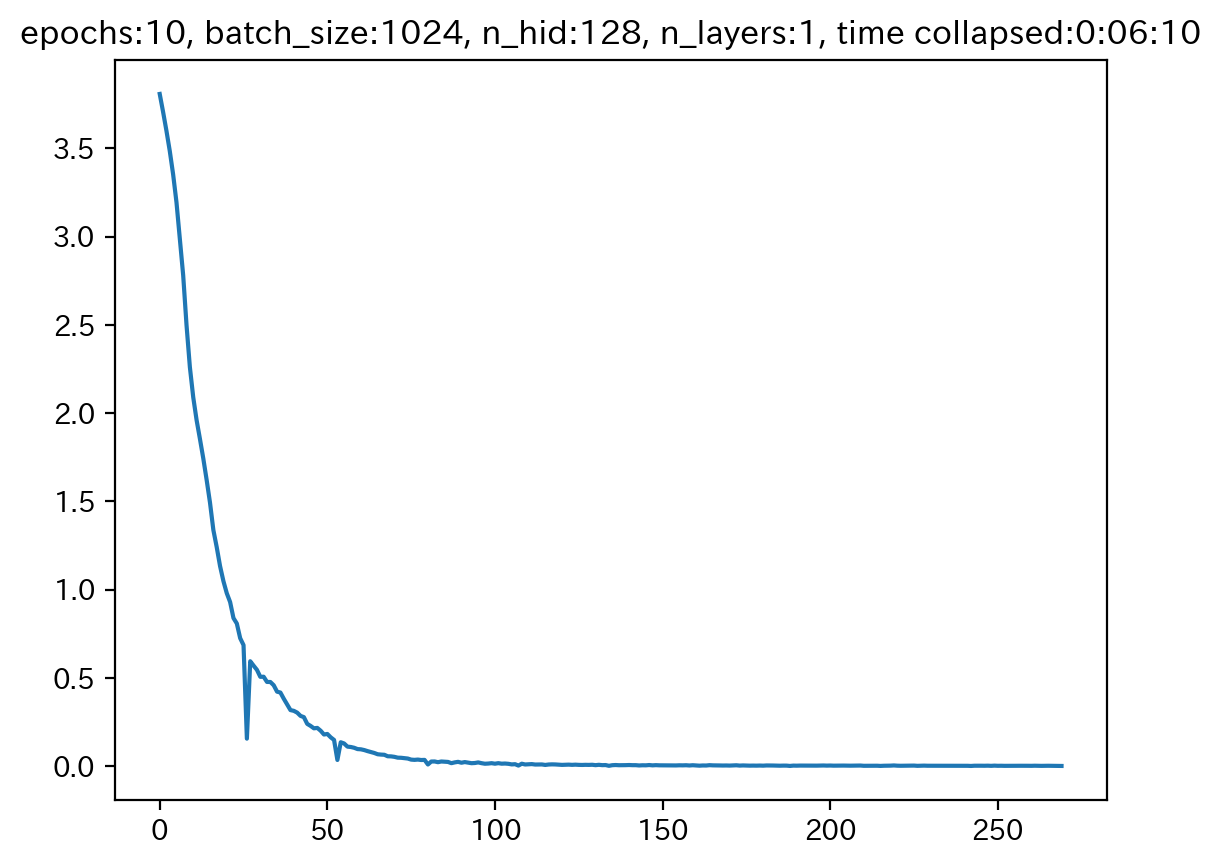

In [ ]:
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
start_time = time.time()   # 開始時刻の保存

# ハイパーパラメータの設定
n_hid = 128
n_layers = 1
epochs = 10
bidirectional=True

# モデルの定義
model = EncDec_w_Att(enc_vocab_size=len(_psylex71_ds.phoneme),
                     dec_vocab_size=len(_psylex71_ds.phoneme),
                     n_layers=n_layers,
                     bidirectional=bidirectional,
                     n_hid=n_hid).to(device)

ds = _psylex71_ds_p2p

# データローダの定義
batch_size = 1024
dataloader = DataLoader(dataset=ds,
#dataloader = DataLoader(dataset=_psylex71_ds_s2p,
#dataloader = DataLoader(dataset=_psylex71_ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=_collate_fn)

optimizer = optim.Adam(model.parameters(),lr=0.001) # 最適化関数の定義
criterion = nn.CrossEntropyLoss(ignore_index=-1)    # 損失関数

# 訓練ループ
model.train()
interval = int(ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)[:,:]
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/batch_size:.3f}')


end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

## 1.3 結果の検証

In [ ]:
isPrint = True
errors = []
model.eval()
for N in tqdm(range(_psylex71_ds.__len__())):
    x =_psylex71_ds.__getitem__(N)[1].to(device)

    enc_inp, dec_inp = x[1:].unsqueeze(0), x[:-1].unsqueeze(0)
    y = model(enc_inp, dec_inp).to('cpu')
    y_ids = np.argmax(y.squeeze(0).detach().numpy(), axis=1)[1:]
    y_phon = _psylex71_ds.phon_ids2phn(y_ids)
    grand_truth = _psylex71_ds.getitem(N)

    n_correct = np.array((y_ids == grand_truth[2]).sum())
    isOK = n_correct == len(grand_truth[2])

    if not isOK:
        errors.append((N,y_ids))
        if isPrint:
            color = 'grey' if isOK else 'red'
            print(colored((f'idx:{N:5d}',
                           f'出力:{y_phon}',
                           #f'出力ID:{y_ids}',
                           #f'{grand_truth[2]}',
                           f'正解:{_psylex71_ds.phon_ids2phn(grand_truth[2])}',
                           f'単語:{grand_truth[0]}',
                          ), color, attrs=['bold']))

cr = len(errors) / N
#cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}%')

  0%|          | 0/26877 [00:00<?, ?it/s]

('idx:   30', '出力:poumei', '正解:hyoumei', '単語:表明')
('idx:   47', '出力:<SOW>atemono', '正解:tatemono', '単語:建物')
('idx:   51', '出力:<SOW>aifuu', '正解:taifuu', '単語:台風')
('idx:   63', '出力:dou<SOW>aku', '正解:doumyaku', '単語:動脈')
('idx:   69', '出力:<SOW>eioN', '正解:teioN', '単語:低温')
('idx:   80', '出力:sousi', '正解:hyousi', '単語:表紙')
('idx:   87', '出力:<SOW>ikei', '正解:tikei', '単語:地形')
('idx:  101', '出力:ju<SOW>ou', '正解:jumyou', '単語:寿命')
('idx:  110', '出力:jdokoro', '正解:idokoro', '単語:居所')
('idx:  135', '出力:<SOW>ame', '正解:tame', '単語:ため')
('idx:  202', '出力:haQaou', '正解:haQpyou', '単語:発表')
('idx:  204', '出力:<SOW>uyoi', '正解:tuyoi', '単語:強い')
('idx:  221', '出力:<SOW>uzuku', '正解:tuzuku', '単語:続く')
('idx:  244', '出力:<SOW>iiki', '正解:tiiki', '単語:地域')
('idx:  267', '出力:<SOW>aisaku', '正解:taisaku', '単語:対策')
('idx:  284', '出力:<SOW>aikai', '正解:taikai', '単語:大会')
('idx:  296', '出力:jjou', '正解:ijou', '単語:以上')
('idx:  298', '出力:<SOW>aisyou', '正解:taisyou', '単語:対象')
('idx:  301', '出力:<SOW>aiou', '正解:taiou', '単語:対応')
('idx:  303', '出力:

# 2 産出モデル **意味から音韻**

## 2.1 モデルの定義

In [ ]:
# Define model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EncDec_s2p(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()

        # 単語の意味ベクトル a.k.a 埋め込み表現 を decoder の中間層に接続するための変換層
        # 別解としては，入力層に接続する方法があるが，それはまた別実装にする
        self.enc_transform_layer = nn.Linear(in_features=sem_dim,
                                             out_features=n_hid)
        self.decoder_emb = nn.Embedding(num_embeddings=dec_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        self.decoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # 最終出力層
        self.out_layer = nn.Linear(n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):
        enc_emb = self.enc_transform_layer(enc_inp)
        hnx, cnx = enc_emb.clone(), enc_emb.clone()
        dec_emb = self.decoder_emb(dec_inp)
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))
        return self.out_layer(dec_out)

n_hid = 64
n_layers = 1
bidirectional=False
# 直下行で，enc_vocab_size と dec_vocab_size を phoneme にしているので，音韻複勝課題に相当する
enc_dec = EncDec_s2p(sem_dim=_psylex71_ds.w2v.vector_size,
                     dec_vocab_size=len(_psylex71_ds.phoneme),
                     n_layers=n_layers,
                     bidirectional=bidirectional,
                     n_hid=n_hid).to(device)
enc_dec.eval()

EncDec_s2p(
  (enc_transform_layer): Linear(in_features=200, out_features=64, bias=True)
  (decoder_emb): Embedding(45, 64, padding_idx=0)
  (decoder): LSTM(64, 64, batch_first=True)
  (out_layer): Linear(in_features=64, out_features=45, bias=True)
)

## 2.2 訓練の実施

epoch: 0, batch: 6, loss:348.843
epoch: 0, batch:12, loss:290.331
epoch: 0, batch:18, loss:222.122
epoch: 0, batch:24, loss:161.732
epoch: 1, batch: 6, loss:102.278
epoch: 1, batch:12, loss:75.777
epoch: 1, batch:18, loss:53.741
epoch: 1, batch:24, loss:41.062
epoch: 2, batch: 6, loss:27.205
epoch: 2, batch:12, loss:21.594
epoch: 2, batch:18, loss:16.248
epoch: 2, batch:24, loss:14.609
epoch: 3, batch: 6, loss:10.511
epoch: 3, batch:12, loss:8.615
epoch: 3, batch:18, loss:7.252
epoch: 3, batch:24, loss:7.061
epoch: 4, batch: 6, loss:5.560
epoch: 4, batch:12, loss:4.850
epoch: 4, batch:18, loss:4.682
epoch: 4, batch:24, loss:4.102
epoch: 5, batch: 6, loss:3.516
epoch: 5, batch:12, loss:3.261
epoch: 5, batch:18, loss:3.264
epoch: 5, batch:24, loss:2.570
epoch: 6, batch: 6, loss:2.726
epoch: 6, batch:12, loss:2.513
epoch: 6, batch:18, loss:1.943
epoch: 6, batch:24, loss:1.826
epoch: 7, batch: 6, loss:1.663
epoch: 7, batch:12, loss:2.004
epoch: 7, batch:18, loss:1.369
epoch: 7, batch:24, l

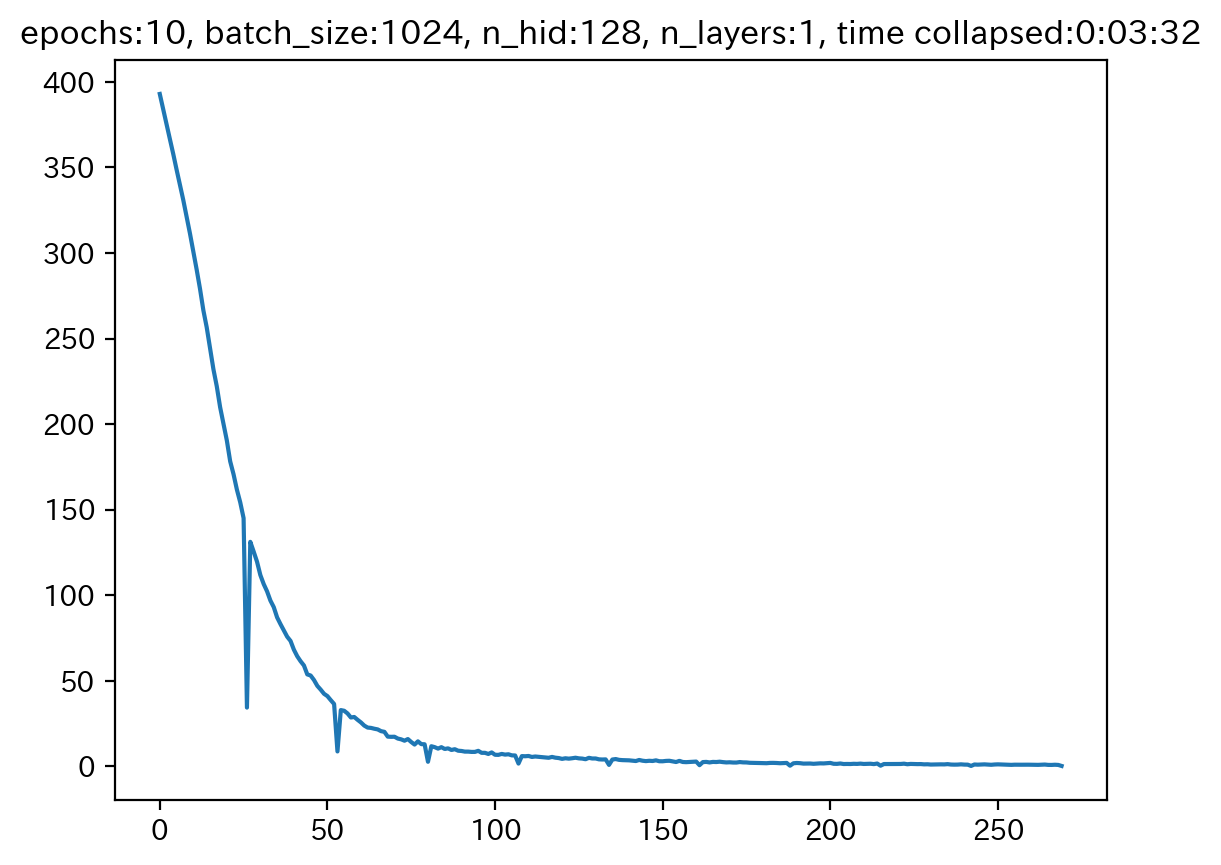

In [ ]:
start_time = time.time()
n_hid = 64
n_hid = 128
n_layers = 1
epochs = 10
bidirectional=False
ds = _psylex71_ds_s2p
enc_dec = EncDec_s2p(sem_dim=ds.w2v.vector_size,
                     dec_vocab_size=len(ds.phoneme),
                     n_layers=n_layers,
                     bidirectional=bidirectional,
                     n_hid=n_hid).to(device)


# データローダの定義
batch_size = 1024
dataloader = DataLoader(dataset=ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=_collate_fn)

model = EncDec_s2p(sem_dim=ds.w2v.vector_size,
                   #model = EncDec_s2p(sem_dim=_psylex71_ds.w2v.vector_size,
                   dec_vocab_size=len(ds.phoneme),
                   #dec_vocab_size=len(_psylex71_ds.phoneme),
                   n_layers=n_layers,
                   bidirectional=bidirectional,
                   n_hid=n_hid).to(device)

optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

model.train()
interval = int(ds.__len__()/batch_size) >> 2
#interval = int(_psylex71_ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        #print(f'len(_inp):{len(_inp)} {_inp[0].size()}')
        enc_inp = torch.tensor(np.array([x.detach().numpy() for x in _inp])).to(device).unsqueeze(0)
        #enc_inp = torch.from_numpy(np.array(_inp)).to(device).unsqueeze(0)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/len(x))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(x):.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

## 2.3 学習結果の評価

In [ ]:
model.eval()
isPrint = True
errors = []
for N in tqdm(range(ds.__len__())):
#for N in tqdm(range(_psylex71_ds.__len__())):
#for N in np.random.permutation(_psylex71_ds.__len__())[:100]:
    x, y = ds.__getitem__(N)
    enc_inp = torch.from_numpy(np.array(x)).to(device).unsqueeze(0)
    enc_emb = model.enc_transform_layer(enc_inp)
    hnx, cnx = enc_emb.clone(), enc_emb.clone()
    dec_inp = y.to(device)
    dec_emb = model.decoder_emb(dec_inp)
    dec_out, (hny, cny) = model.decoder(dec_emb,(hnx, cnx))
    dec_out = model.out_layer(dec_out)
    y_ids = np.argmax(dec_out.detach().cpu().numpy(),axis=1)

    n_correct = np.array((y_ids[1:-1] == _psylex71_ds.getitem(N)[2]).sum())
    isOK = n_correct == len(_psylex71_ds.getitem(N)[2])
    color = 'grey' if isOK else 'red'

    if not isOK:
        errors.append((N,y_ids))
        if isPrint:
            print(colored((f'{N:05d}', #y_ids,
                           "".join(p for p in _psylex71_ds.phon_ids2phn(y_ids[1:-1]))),color,attrs=["bold"]), end=" ")
            print(_psylex71_ds.getitem(N))

cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}')


  0%|          | 0/26877 [00:00<?, ?it/s]

('00202', 'haQkyou') ('発表', ['h', 'a', 'Q', 'py', 'o', 'u'], [24, 4, 15, 34, 8, 6], [2033, 2102])
('01008', 'koNau:ta:') ('コンピューター', ['k', 'o', 'N', 'py', 'u:', 't', 'a:'], [27, 8, 14, 34, 11, 39, 9], [162, 221, 194, 237, 265, 174, 265])
('01682', 'erioiN') ('エリツィン', ['e', 'r', 'i', 'ty', 'i', 'N'], [7, 35, 5, 40, 5, 14], [152, 213, 178, 228, 221])
('04853', 'puroou:sa:') ('プロデューサー', ['p', 'u', 'r', 'o', 'dy', 'u:', 's', 'a:'], [33, 6, 35, 8, 20, 11, 37, 9], [197, 216, 181, 237, 265, 164, 265])
('05129', 'bosuniaheruoegobina') ('ボスニアヘルツェゴビナ', ['b', 'o', 's', 'u', 'n', 'i', 'a', 'h', 'e', 'r', 'u', 'ty', 'e', 'g', 'o', 'b', 'i', 'n', 'a'], [16, 8, 37, 6, 31, 5, 4, 24, 7, 35, 6, 40, 7, 22, 8, 16, 5, 31, 4], [202, 168, 185, 149, 198, 214, 178, 232, 163, 193, 184])
('07923', 'roNaou') ('論評', ['r', 'o', 'N', 'py', 'o', 'u'], [35, 8, 14, 34, 8, 6], [2512, 2105])
('08179', 'mo:o:aruto') ('モーツァルト', ['m', 'o:', 'ty', 'a', 'r', 'u', 't', 'o'], [29, 13, 40, 4, 35, 6, 39, 8], [208, 265, 178, 227, 

# 3 理解モデル 音韻から意味

## 3.1 モデルの定義


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EncDec_p2s(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 enc_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()
        self.encoder_emb = nn.Embedding(num_embeddings=enc_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        self.encoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        bi_fact = 2 if bidirectional else 1
        self.out_layer = nn.Linear(in_features=n_hid * bi_fact,
                                   out_features=sem_dim)

    def forward(self, enc_inp):
        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hid, cel) = self.encoder(enc_emb)
        _sem = self.out_layer(hid)
        return _sem, enc_out


n_hid = 64
n_layers = 1
bidirectional=False
model = EncDec_p2s(sem_dim=_psylex71_ds.w2v.vector_size,
                   enc_vocab_size=len(_psylex71_ds.phoneme),
                   n_hid=n_hid,
                   n_layers=n_layers,
                   bidirectional=bidirectional)
model.eval()

EncDec_p2s(
  (encoder_emb): Embedding(45, 64, padding_idx=0)
  (encoder): LSTM(64, 64, batch_first=True)
  (out_layer): Linear(in_features=64, out_features=200, bias=True)
)

## 3.2 訓練の実施

In [ ]:
start_time = time.time()
n_hid = 256
n_layers = 1
epochs = 20
bidirectional=False
ds = _psylex71_ds_p2s

# データローダの定義
batch_size = 1024
dataloader = DataLoader(dataset=ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=_collate_fn)

model = EncDec_p2s(sem_dim=ds.w2v.vector_size,
                   enc_vocab_size=len(ds.phoneme),
                   n_layers=n_layers,
                   bidirectional=bidirectional,
                   n_hid=n_hid).to(device)

#optimizer = optim.Adam(model.parameters(),lr=0.001)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion_dec = nn.MSELoss()
criterion_enc = nn.CrossEntropyLoss(ignore_index=-1)

model.train()
interval = int(ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        tch = torch.tensor([x.detach().numpy() for x in _tch]).to(device)
        #tch = torch.tensor([_x.detach().numpy() for _x in x]).to(device)

        out, enc_out = model(enc_inp)
        loss = criterion_dec(out, tch)

        for _x, _y in zip(enc_out[:,:-1], enc_inp[:,1:]):
            loss += criterion_enc(_x, _y)
        losses.append(loss.item()/batch_size)
        #losses.append(loss.item()/len(x))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(x):.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

epoch: 0, batch: 6, loss:28.249
epoch: 0, batch:12, loss:28.104
epoch: 0, batch:18, loss:27.868
epoch: 0, batch:24, loss:27.730


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([253, 200])) that is different to the input size (torch.Size([1, 253, 200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1, batch: 6, loss:27.425
epoch: 1, batch:12, loss:27.297
epoch: 1, batch:18, loss:26.621
epoch: 1, batch:24, loss:26.118
epoch: 2, batch: 6, loss:25.387
epoch: 2, batch:12, loss:24.911
epoch: 2, batch:18, loss:24.548
epoch: 2, batch:24, loss:24.219
epoch: 3, batch: 6, loss:23.816
epoch: 3, batch:12, loss:23.407
epoch: 3, batch:18, loss:23.269
epoch: 3, batch:24, loss:23.137
epoch: 4, batch: 6, loss:22.719
epoch: 4, batch:12, loss:22.378
epoch: 4, batch:18, loss:22.327
epoch: 4, batch:24, loss:22.218
epoch: 5, batch: 6, loss:21.676
epoch: 5, batch:12, loss:21.465
epoch: 5, batch:18, loss:21.315
epoch: 5, batch:24, loss:21.100
epoch: 6, batch: 6, loss:20.865
epoch: 6, batch:12, loss:20.890
epoch: 6, batch:18, loss:20.632
epoch: 6, batch:24, loss:20.439
epoch: 7, batch: 6, loss:20.471
epoch: 7, batch:12, loss:20.144
epoch: 7, batch:18, loss:20.346
epoch: 7, batch:24, loss:20.128
epoch: 8, batch: 6, loss:20.031


## 3.3 学結果の評価

In [ ]:
model.eval()
isPrint = False
errors = []
for N in tqdm(range(ds.__len__())):
#for N in np.random.permutation(ds.__len__())[:2]:
    x, y = ds.__getitem__(N)
    enc_inp = x.to(device).unsqueeze(0)
    out, enc_out = model(enc_inp)
    out = out.detach().squeeze().numpy()
    print(N)
    print(ds.getitem(N)[0])
    print(ds.w2v.similar_by_vector(out,topn=3))
    break

cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}')


# 4 書記から意味


# 5 意味から書記

#